# Import Libraries

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import datasets, models, transforms
from torch import nn, optim
import torch.nn.functional as F
from sklearn import datasets
from sklearn.model_selection import train_test_split
import time
import os
import copy

from torchvision.utils import make_grid
from torchsummary import summary
from sklearn import preprocessing

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cuda:0


#Datasets

##MNIST

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    ])
mnist_train = torchvision.datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
mnist_test = torchvision.datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# create batches
mnist_train_dataloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_dataloader = DataLoader(mnist_test, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



##CIFAR10

In [3]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
    ])

cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=preprocess)

cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=preprocess)

cifar10_train_dataloader = torch.utils.data.DataLoader(cifar10_train, batch_size=64, shuffle=True)
cifar10_test_dataloader = torch.utils.data.DataLoader(cifar10_test, batch_size=64, shuffle=False)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


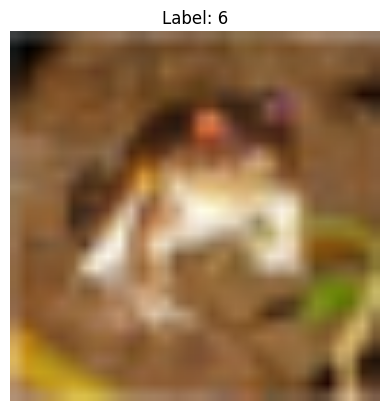

In [4]:
# Get one image and label from the dataset
image, label = cifar10_train[0]

# Convert the tensor to a NumPy array for plotting
image = image.permute(1, 2, 0).numpy()

# Plot the image
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')  # Hide the axes
plt.show()

##Flower102

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

flowers102_train = torchvision.datasets.Flowers102(
    root="./data",  # Directory where data will be downloaded
    split="train",  # You can choose "train", "val", or "test"
    download=True,  # Download dataset if not already present
    transform=transform  # Apply transformations to images
)

flowers102_test = torchvision.datasets.Flowers102(
    root="./data",
    split="test",
    download=True,
    transform=transform
)

flowers102_train_dataloader = DataLoader(flowers102_train, batch_size=64, shuffle=True)
flowers102_test_dataloader = DataLoader(flowers102_test, batch_size=64, shuffle=True)

100.0%


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100.0%


100.0%


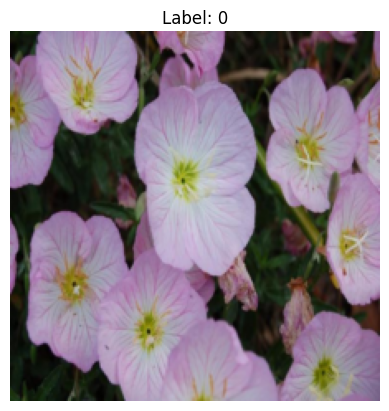

In [6]:
# Get one image and label from the dataset
image, label = flowers102_train[0]

# Convert the tensor to a NumPy array for plotting
image = image.permute(1, 2, 0).numpy()

# Plot the image
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')  # Hide the axes
plt.show()

# Generative Adversarial Network (GAN)

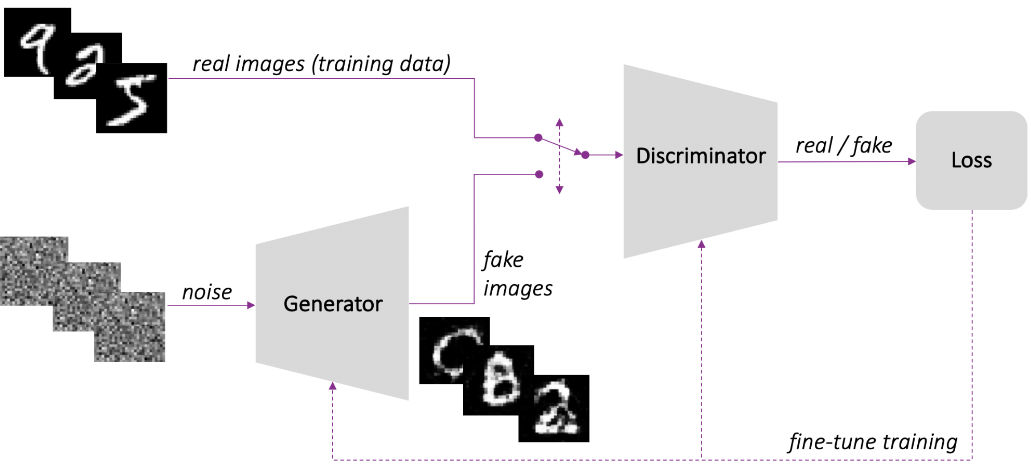

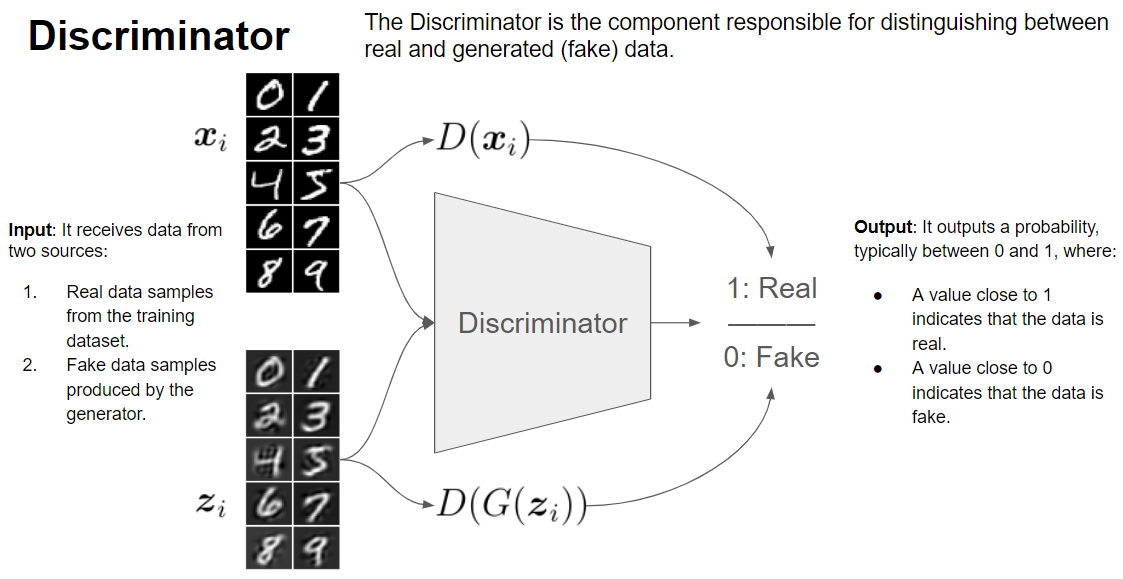

In [176]:
class Discriminator(nn.Module):
    def __init__(self,**kwargs):
        super(Discriminator,self).__init__(**kwargs)
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            #fix below layer. don't change
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.net(x)

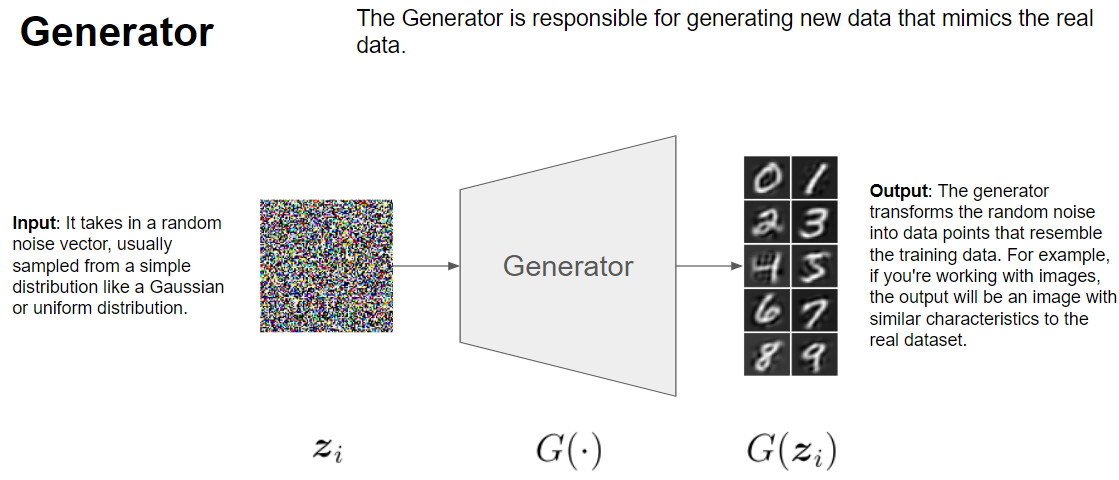

In [177]:
class Generator(nn.Module):
    def __init__(self,**kwargs):
        super(Generator,self).__init__(**kwargs)
        self.net = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Tanh(), # don't know: no clue, but it works T-T.
        )

    def forward(self, batch_size):
        z = torch.randn(batch_size, 100).to(device) # Normal distribution
        return self.net(z).view(-1, 28, 28)

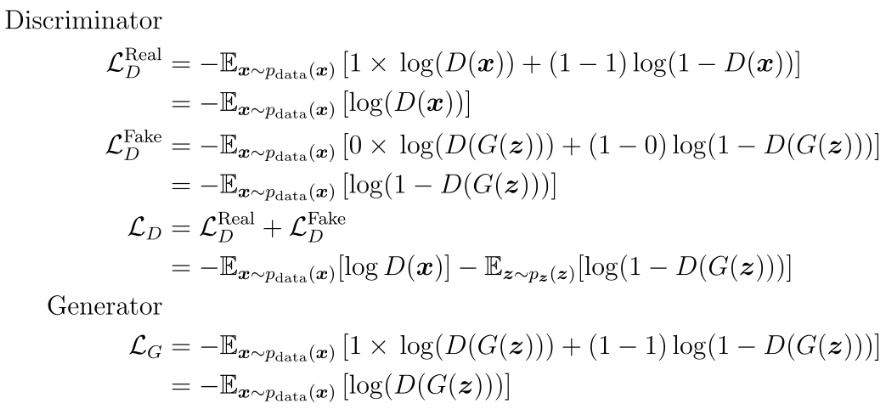

In [178]:
def train_gan(
        dataloader,
        d_net,
        g_net,
        # fix BCE!! because can't separate Loss real/ fake
        criterion = nn.BCELoss(),
        lr = 0.001,
        epochs = 20,
        optimizer = optim.Adam,
        ):
    d_optimizer = optimizer(d_net.parameters(), lr=lr)
    g_optimizer = optimizer(g_net.parameters(), lr=lr)

    for epoch in range(epochs):
        d_losses = []
        g_losses = []
        for images, labels in dataloader:
            batch_size = images.size(0) # some last batch may not with full size, but remain data.

            images = images.to(device)
            real_label = torch.ones(batch_size, 1).to(device) # class 1
            fake_label = torch.zeros(batch_size, 1).to(device) # class 0
            g_net.eval()
            with torch.no_grad():
                generated_images = g_net(batch_size)

            #===============================
            # Discriminator Network Training
            #===============================
            d_net.train()
            d_loss = criterion(d_net(images), real_label)
            d_loss += criterion(d_net(generated_images), fake_label)

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            #===============================
            # Generator Network Training
            #===============================
            g_net.train()
            generated_images = g_net(batch_size)
            d_net.eval() # turn off switch to train fake
            g_loss = criterion(d_net(generated_images), real_label)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

        print(f"epoch:{epoch}, discriminator's loss:{np.mean(d_losses)}, generator's loss:{np.mean(g_losses)}")

        if (epoch)%5==0:
            g_net.eval()
            with torch.no_grad():
                fake = g_net(100)

            images = fake.detach().to("cpu").view(-1, 1, 28, 28)
            images_grid = make_grid(images, nrow=10)
            plt.imshow(images_grid.permute(1, 2, 0).squeeze())
            plt.show()

# You can use gan to generate imblance data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4947101..0.95206565].


epoch:0, discriminator's loss:0.5689232181467271, generator's loss:5.448221566707595


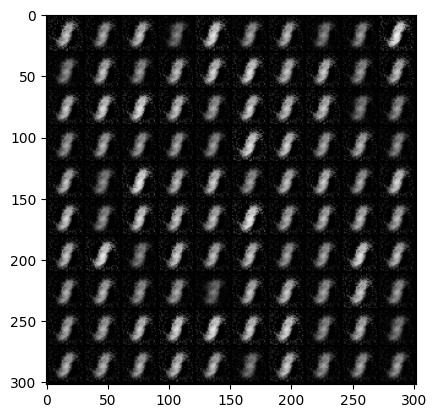

epoch:1, discriminator's loss:0.5185789550815437, generator's loss:4.296977945228122
epoch:2, discriminator's loss:0.4091146072980437, generator's loss:4.681866358211046
epoch:3, discriminator's loss:0.26679348393972874, generator's loss:5.023187296731131
epoch:4, discriminator's loss:0.20318309528066086, generator's loss:5.881077842671734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98266834..0.999902].


epoch:5, discriminator's loss:0.19049164237800056, generator's loss:6.161818685053762


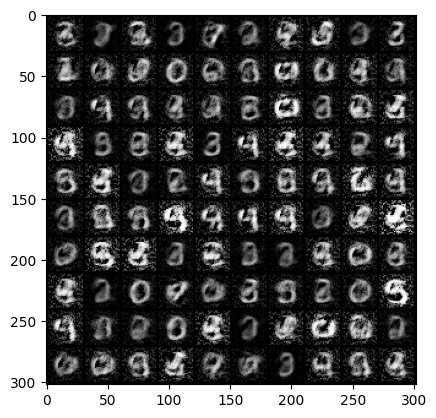

epoch:6, discriminator's loss:0.14045813814230534, generator's loss:6.424359565350547
epoch:7, discriminator's loss:0.1180454687456658, generator's loss:6.700439695356243
epoch:8, discriminator's loss:0.10152026455698492, generator's loss:6.825609111582547
epoch:9, discriminator's loss:0.09040949361593421, generator's loss:7.259395859643086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9400208..0.9996971].


epoch:10, discriminator's loss:0.09498188280706991, generator's loss:7.1590395568530445


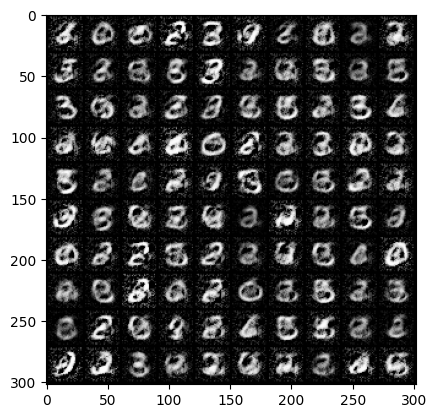

epoch:11, discriminator's loss:0.08085971117974805, generator's loss:7.2905311853900905
epoch:12, discriminator's loss:0.07492935066439037, generator's loss:7.767293883285034
epoch:13, discriminator's loss:0.07449796323916182, generator's loss:7.533158417195399
epoch:14, discriminator's loss:0.07212591139914425, generator's loss:7.378345644041928


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9618563..0.9999838].


epoch:15, discriminator's loss:0.06907155082475688, generator's loss:7.695473048224378


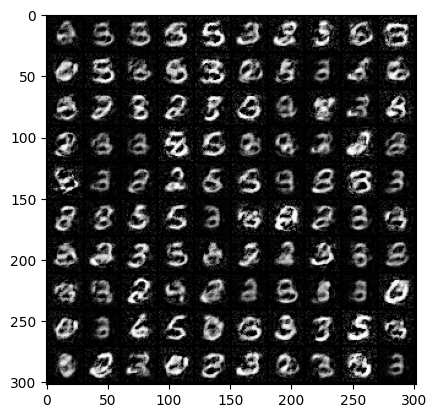

epoch:16, discriminator's loss:0.07031151254066645, generator's loss:7.572515172490688
epoch:17, discriminator's loss:0.055133713612348825, generator's loss:7.723668188936929
epoch:18, discriminator's loss:0.046919111507202085, generator's loss:7.864883676520797
epoch:19, discriminator's loss:0.026466146888669988, generator's loss:8.15790612712852


In [179]:
g_net = Generator().to(device)
d_net = Discriminator().to(device)
train_gan(dataloader=mnist_train_dataloader, d_net=d_net, g_net=g_net)

# Transfer Learning

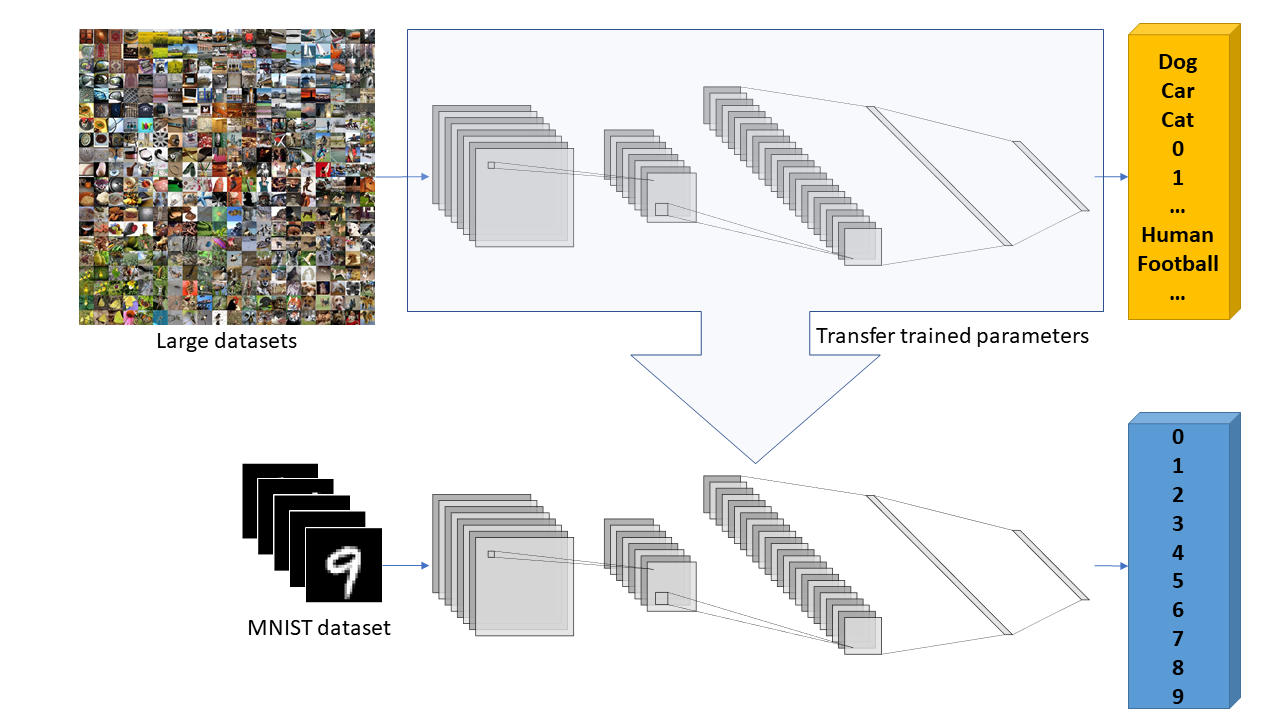

https://pytorch.org/vision/main/models.html

In [12]:
weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
model = models.efficientnet_b0(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/jimmy/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100.0%


In [16]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
weights.get_state_dict(progress=True)

OrderedDict([('features.0.0.weight',
              tensor([[[[ 1.2156e-01,  6.5634e-01,  4.5671e-01],
                        [-1.1092e-01, -6.1004e-01, -3.3345e-01],
                        [ 2.7964e-02, -1.0312e-01, -1.0324e-01]],
              
                       [[ 6.3553e-02,  1.6552e+00,  1.7436e+00],
                        [-1.3646e-01, -1.5367e+00, -1.5937e+00],
                        [ 5.0196e-02, -1.1360e-01, -1.2600e-01]],
              
                       [[ 8.7276e-02,  3.6126e-01,  2.6946e-01],
                        [-1.1966e-01, -2.8122e-01, -2.1883e-01],
                        [ 3.6658e-02, -7.0751e-02, -8.1917e-02]]],
              
              
                      [[[ 1.6449e-01, -2.0041e-01,  8.3092e-02],
                        [ 8.9009e-01, -1.2110e+00,  2.7610e-01],
                        [ 1.0740e+00, -1.2603e+00,  2.0645e-01]],
              
                       [[ 3.2816e-01, -4.3449e-01,  1.8769e-01],
                        [ 1.6213e+00, 

In [18]:
print(model.named_modules)

<bound method Module.named_modules of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
      

In [19]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

The typical process of transfer learning involves freezing some base layers of a pre-trained model.

> **Note:** To *freeze* layers means to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [20]:
for param in model.parameters():
    param.requires_grad = False

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [21]:
cifar10_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Feature extractor layers frozen!

Let's now adjust the output layer or the `classifier` portion of our pretrained model to our needs.

Right now our pretrained model has `out_features=1000` because there are 1000 classes in ImageNet.

However, we don't have 1000 classes, we only have 10 classes (`'airplane'`,`'automobile'`,`'bird'`,`'cat'`,`'deer'`,`'dog'`,`'frog'`,`'horse'`,`'ship'`,`'truck'`).

We can change the `classifier` portion of our model by creating a new series of layers.

The current `classifier` consists of:

```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

We'll keep the `Dropout` layer the same using [`torch.nn.Dropout(p=0.2, inplace=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

In [22]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=10),
)

print(model.named_modules)

<bound method Module.named_modules of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
      

In [ ]:
model.to(device)

In [27]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

#Workshop

Create a custom GAN for Flower102 dataset using
1. A custom generator for 224*224 color images.
2. Transfer learning-based discriminator using `mobilenet_v3_small` parameters.
3. Create a training function for a given model.
4. Show a image result obtained from your generator.

## Conv2d-based generator.

In [270]:
class Generator(nn.Module):
    def __init__(self,**kwargs):
        super(Generator,self).__init__(**kwargs)
        self.net = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
            # [-1, 3, 224, 224]
        )
    def forward(self, batch_size):
        # z = torch.randn(1, 1024, 7, 7).to(device) #For create
        z = torch.randn(batch_size, 1024, 7, 7).to(device) #For train
        return self.net(z)

# summary(Generator(), input_size=(1,))

## Transfer learning-based discriminator using [mobilenet_v3_small](https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_small.html#torchvision.models.MobileNet_V3_Small_Weights) parameters.



In [29]:
weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
model = models.mobilenet_v3_small(weights=weights)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /home/jimmy/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100.0%


In [30]:
print(model.named_modules)

<bound method Module.named_modules of MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0

In [33]:
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [34]:
for param in model.parameters():
    param.requires_grad = False

In [35]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

In [36]:
model.classifier

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)

In [37]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=576, out_features=1024, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1024,1),
    nn.Sigmoid()
)


## Create a training function for a given model.



In [292]:

def train_gan(
        dataloader,
        d_net,
        g_net,
        # fix BCE!! because can't separate Loss real/ fake
        criterion = nn.BCELoss(),
        lr = 0.001,
        epochs = 30,
        optimizer = optim.Adam,
        ):
    d_optimizer = optimizer(d_net.parameters(), lr=lr)
    g_optimizer = optimizer(g_net.parameters(), lr=lr)

    for epoch in range(epochs):
        d_losses = []
        g_losses = []
        for images, labels in dataloader:
            batch_size = images.size(0) # some last batch may not with full size, but remain data.

            images = images.to(device)
            real_label = torch.ones(batch_size, 1).to(device) # class 1
            fake_label = torch.zeros(batch_size, 1).to(device) # class 0
            g_net.eval()
            with torch.no_grad():
                generated_images = g_net(batch_size)

            #===============================
            # Discriminator Network Training
            #===============================
            d_net.train()
            d_loss = criterion(d_net(images), real_label)
            d_loss += criterion(d_net(generated_images), fake_label)

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            #===============================
            # Generator Network Training
            #===============================
            g_net.train()
            generated_images = g_net(batch_size)
            d_net.eval() # turn off switch to train fake
            g_loss = criterion(d_net(generated_images), real_label)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

        print(f"epoch:{epoch}, discriminator's loss:{np.mean(d_losses)}, generator's loss:{np.mean(g_losses)}")

        # if (epoch)%5==0:
        #     g_net.eval()
        #     with torch.no_grad():
        #         fake = g_net(100)

        #     images = fake.detach().to("cpu").view(-1, 1, 28, 28)
        #     images_grid = make_grid(images, nrow=10)
        #     plt.imshow(images_grid.permute(1, 2, 0).squeeze())
        #     plt.show()




## Show a image result obtained from your generator.





In [293]:


# flowers102_train_dataloader = DataLoader(flowers102_train, batch_size=64, shuffle=True)
# flowers102_test_dataloader = DataLoader(flowers102_test, batch_size=64, shuffle=True)

g_net = Generator().to(device)
d_net = model.to(device)
train_gan(dataloader=flowers102_train_dataloader, d_net=d_net, g_net=g_net)

epoch:0, discriminator's loss:0.2630876146722585, generator's loss:0.2515923574974295
epoch:1, discriminator's loss:0.09850267833098769, generator's loss:0.017755277716787532
epoch:2, discriminator's loss:0.06650614773388952, generator's loss:0.0028647834042203613
epoch:3, discriminator's loss:0.04703797085676342, generator's loss:0.0017454940534662455
epoch:4, discriminator's loss:0.038863512221723795, generator's loss:0.0014950882250559516
epoch:5, discriminator's loss:0.03805627120891586, generator's loss:0.0014685216519865207
epoch:6, discriminator's loss:0.03210752678569406, generator's loss:0.0007172860432547168
epoch:7, discriminator's loss:0.029957477177958935, generator's loss:0.00010274313854097272
epoch:8, discriminator's loss:0.022641581716015935, generator's loss:0.00015676177190471208
epoch:9, discriminator's loss:0.02826329763047397, generator's loss:0.00010956818459817441
epoch:10, discriminator's loss:0.02622312164749019, generator's loss:9.641524547987501e-05
epoch:11

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93213516..0.78657836].


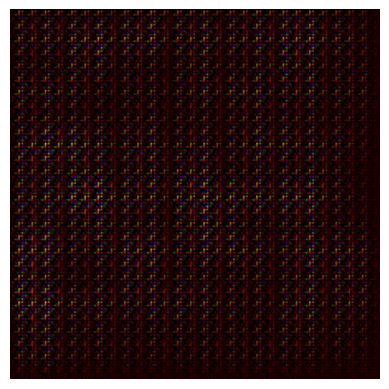

In [305]:
fake = g_net(1)
images = fake.detach().to("cpu").view(-1, 3, 224, 224)
images = images.squeeze()
images = images.permute(1, 2, 0)
plt.imshow(images)
plt.axis('off')
plt.show()
